Baseline Models = Logistic Regression and Decision Trees

In [1]:
# necessary modules
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


In [2]:
# import dataset
merged_df = pd.read_csv('merged_df.csv')

Preprocessing Pipeline

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Define target variables and feature variables
X = merged_df.drop(columns=['DEP_DATE_TIME', 'ACC_DEP_TIME', 'DEP_DELAY_NEW', 'DEP_DELAY_GROUP'])
y = merged_df['DEP_DELAY_GROUP']

# Replace -2 and -1 with 0 in the target labels
y = y.replace({-2: 0, -1: 0})

# Define numerical and categorical columns
categorical_cols = ['ORIGIN', 'DEST']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure encoder learns all categories, even those missing in training
all_categories = {col: X[col].unique() for col in categorical_cols}

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(categories=[all_categories[col] for col in categorical_cols], drop='first', handle_unknown='ignore'), categorical_cols)
    ])

# Preprocess the data (Fit on training data and transform both training and test data)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert to PyTorch tensors
X_train_torch = torch.FloatTensor(X_train_processed.toarray())  # Convert sparse matrix to dense
Y_train_torch = torch.LongTensor(Y_train.values)  # Convert target variable to tensor
X_test_torch = torch.FloatTensor(X_test_processed.toarray())  # Convert sparse matrix to dense
Y_test_torch = torch.LongTensor(Y_test.values)  # Convert target variable to tensor

# Normalize data
scaler = StandardScaler()
X_train_torch = torch.tensor(scaler.fit_transform(X_train_torch), dtype=torch.float32)
X_test_torch = torch.tensor(scaler.transform(X_test_torch), dtype=torch.float32)

# Generate feature names after OneHotEncoding for categorical columns
categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(categorical_feature_names)

# Debugging: Print categories learned by OneHotEncoder
print("Categories learned by OneHotEncoder:", preprocessor.named_transformers_['cat'].categories_)

# Now feature_names is the list of all the feature names you need for plotting
print("Feature names:", feature_names)

Categories learned by OneHotEncoder: [array(['JFK'], dtype=object), array(['LAX', 'SFO', 'SJU', 'PHX', 'TPA', 'RSW', 'FLL', 'PBI', 'BQN',
       'MCO', 'ATL', 'MIA', 'STT', 'MSY', 'LAS', 'BOS', 'SLC', 'SRQ',
       'MSP', 'BUR', 'DEN', 'HOU', 'LGB', 'SYR', 'JAX', 'SEA', 'AUS',
       'PWM', 'RIC', 'RDU', 'OAK', 'IAD', 'DTW', 'ORD', 'BTV', 'BUF',
       'ROC', 'SAN', 'DCA', 'CLT', 'PIT', 'CVG', 'PHL', 'BWI', 'EGE',
       'MCI', 'BGR', 'CLE', 'SJC', 'SMF', 'ALB', 'BDL', 'IAH', 'PDX',
       'IND', 'STL', 'MKE', 'BNA', 'ORF', 'PSE', 'DFW', 'CMH', 'MEM',
       'ACK', 'SNA', 'SAT', 'LWB', 'MVY', 'HNL', 'PSP', 'CHS', 'SDF',
       'ABQ', 'BHM', 'JAC', 'SAV', 'HYA', 'RNO', 'DAB', 'TUS', 'ORH'],
      dtype=object)]


Multinomial Logistic Regression

Epoch [10/100], Loss: 2.6841, Accuracy: 0.0862
Epoch [20/100], Loss: 2.6101, Accuracy: 0.1221
Epoch [30/100], Loss: 2.5375, Accuracy: 0.1672
Epoch [40/100], Loss: 2.4662, Accuracy: 0.2244
Epoch [50/100], Loss: 2.3963, Accuracy: 0.2925
Epoch [60/100], Loss: 2.3279, Accuracy: 0.3659
Epoch [70/100], Loss: 2.2610, Accuracy: 0.4323
Epoch [80/100], Loss: 2.1958, Accuracy: 0.4886
Epoch [90/100], Loss: 2.1322, Accuracy: 0.5375
Epoch [100/100], Loss: 2.0702, Accuracy: 0.5816

Training Set Metrics:
Accuracy: 0.5857
Precision: 0.7779
Recall: 0.5857
F1-score: 0.6662

Test Set Metrics:
Accuracy: 0.5887
Precision: 0.7776
Recall: 0.5887
F1-score: 0.6680


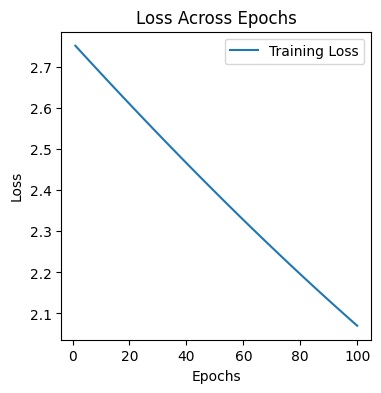

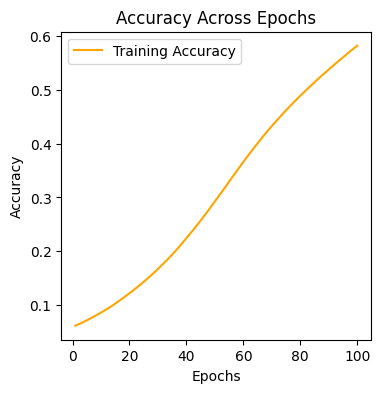

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Define multinomial logistic regression model
class MultinomialLogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultinomialLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)  # Softmax is included in CrossEntropyLoss

# Model, loss, optimizer
input_dim = X_train.shape[1]  # Number of features after preprocessing
output_dim = len(torch.unique(Y_train))
model = MultinomialLogisticRegression(input_dim, output_dim)

criterion = nn.CrossEntropyLoss()  # Includes softmax
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Lists to store loss and accuracy for plotting
train_loss_list = []
train_accuracy_list = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Calculate accuracy for this epoch
    with torch.no_grad():
        y_pred = torch.argmax(outputs, dim=1)
        correct = (y_pred == Y_train).float()
        accuracy = correct.mean()

    # Store loss and accuracy
    train_loss_list.append(loss.item())
    train_accuracy_list.append(accuracy.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

# Evaluate metrics after training
model.eval()  # Set model to evaluation mode

# Get predictions for both training and test sets
with torch.no_grad():
    # Training set predictions
    y_pred_train = torch.argmax(model(X_train), dim=1)
    # Test set predictions
    y_pred_test = torch.argmax(model(X_test), dim=1)

# Convert predictions and labels to numpy arrays for metric calculations
y_train_np = Y_train.cpu().numpy()
y_test_np = Y_test.cpu().numpy()
y_pred_train_np = y_pred_train.cpu().numpy()
y_pred_test_np = y_pred_test.cpu().numpy()

# Calculate accuracy, precision, recall, f1-score for training and test sets
# Training set metrics
train_accuracy = accuracy_score(y_train_np, y_pred_train_np)
train_precision = precision_score(y_train_np, y_pred_train_np, average='weighted')
train_recall = recall_score(y_train_np, y_pred_train_np, average='weighted')
train_f1 = f1_score(y_train_np, y_pred_train_np, average='weighted')

# Test set metrics
test_accuracy = accuracy_score(y_test_np, y_pred_test_np)
test_precision = precision_score(y_test_np, y_pred_test_np, average='weighted')
test_recall = recall_score(y_test_np, y_pred_test_np, average='weighted')
test_f1 = f1_score(y_test_np, y_pred_test_np, average='weighted')

# Print the metrics for both training and test sets
print(f'\nTraining Set Metrics:')
print(f'Accuracy: {train_accuracy:.4f}')
print(f'Precision: {train_precision:.4f}')
print(f'Recall: {train_recall:.4f}')
print(f'F1-score: {train_f1:.4f}')

print(f'\nTest Set Metrics:')
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')
print(f'F1-score: {test_f1:.4f}')

# Plotting Loss separately
epochs = range(1, num_epochs + 1)

# Loss Plot (Adjust the figure size to fit half of A4)
plt.figure(figsize=(4, 4))  # Create a figure for Loss with A4 column size
plt.plot(epochs, train_loss_list, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Across Epochs')
plt.legend()

# Save Loss plot
plt.savefig('training_loss_plot_MLR.png', dpi=300, bbox_inches='tight')
plt.show()

# Plotting Accuracy separately
# Accuracy Plot (Adjust the figure size to fit half of A4)
plt.figure(figsize=(4, 4))  # Create a figure for Accuracy with A4 column size
plt.plot(epochs, train_accuracy_list, label='Training Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Across Epochs')
plt.legend()

# Save Accuracy plot
plt.savefig('training_accuracy_plot_MLR.png', dpi=300, bbox_inches='tight')
plt.show()

Decision Trees

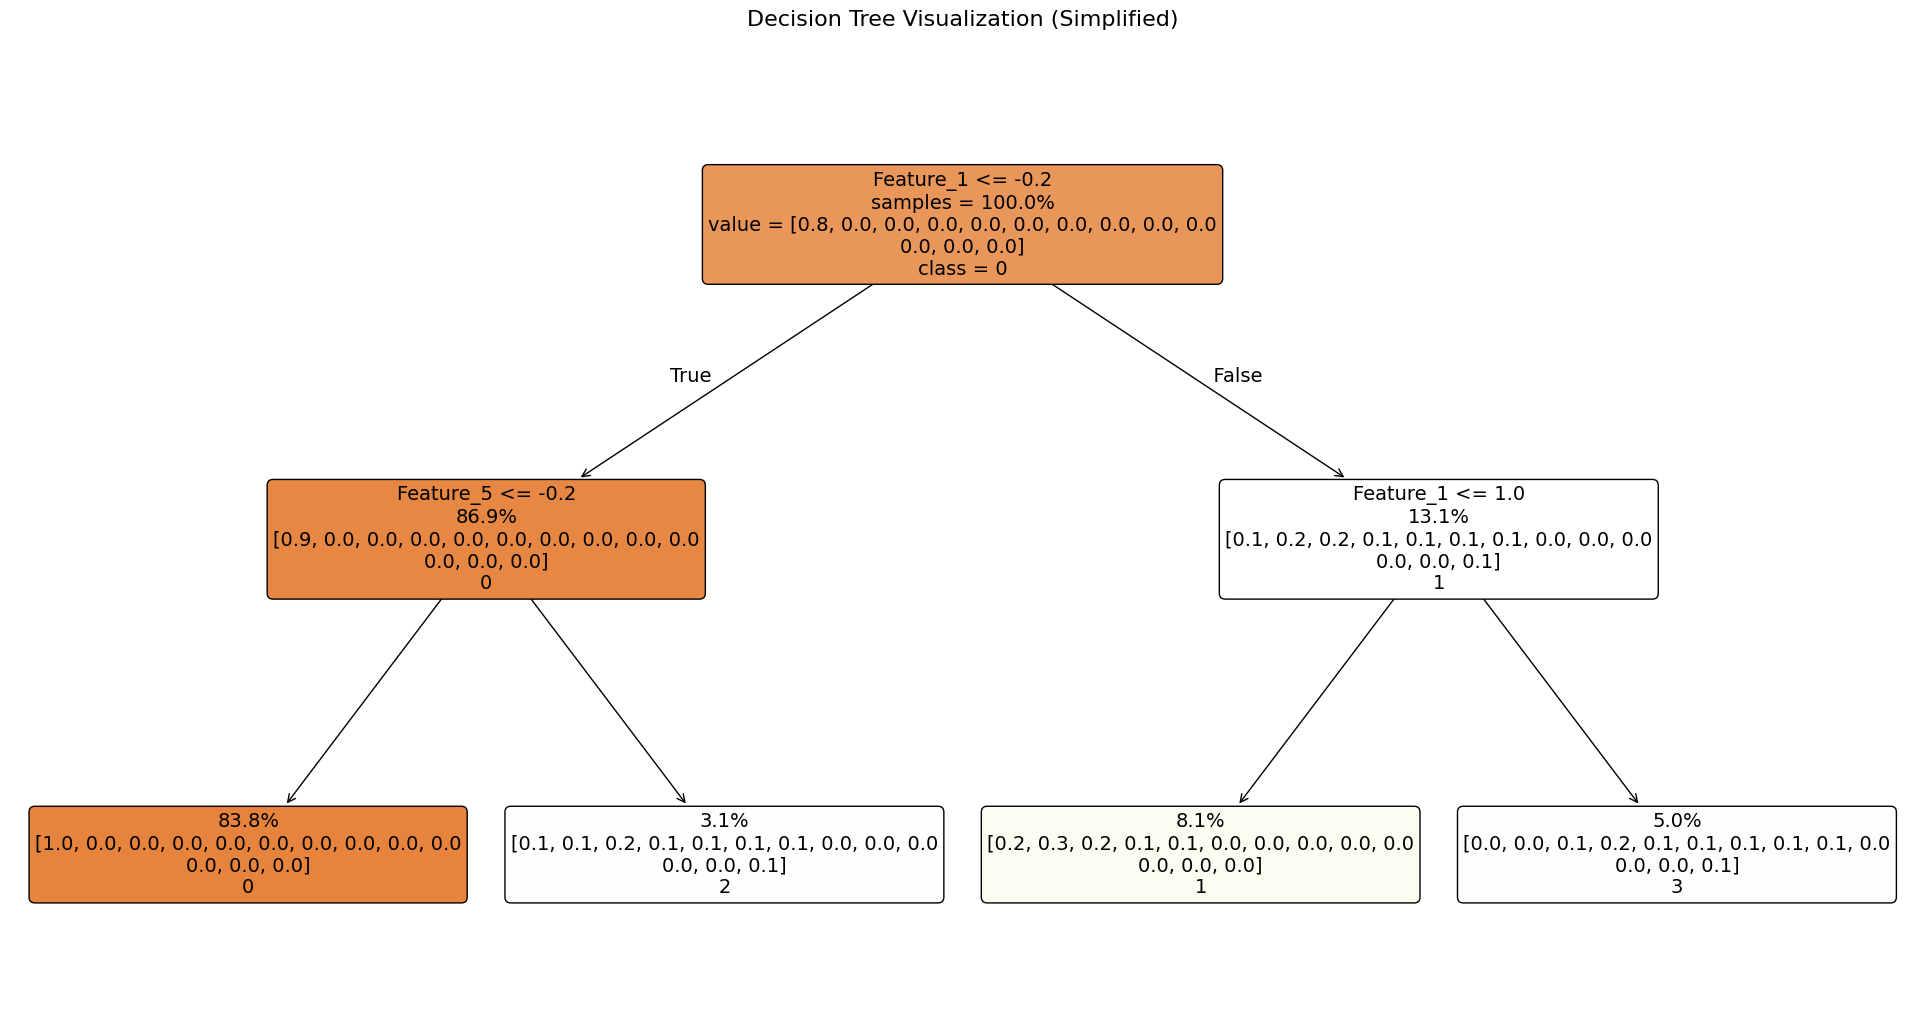

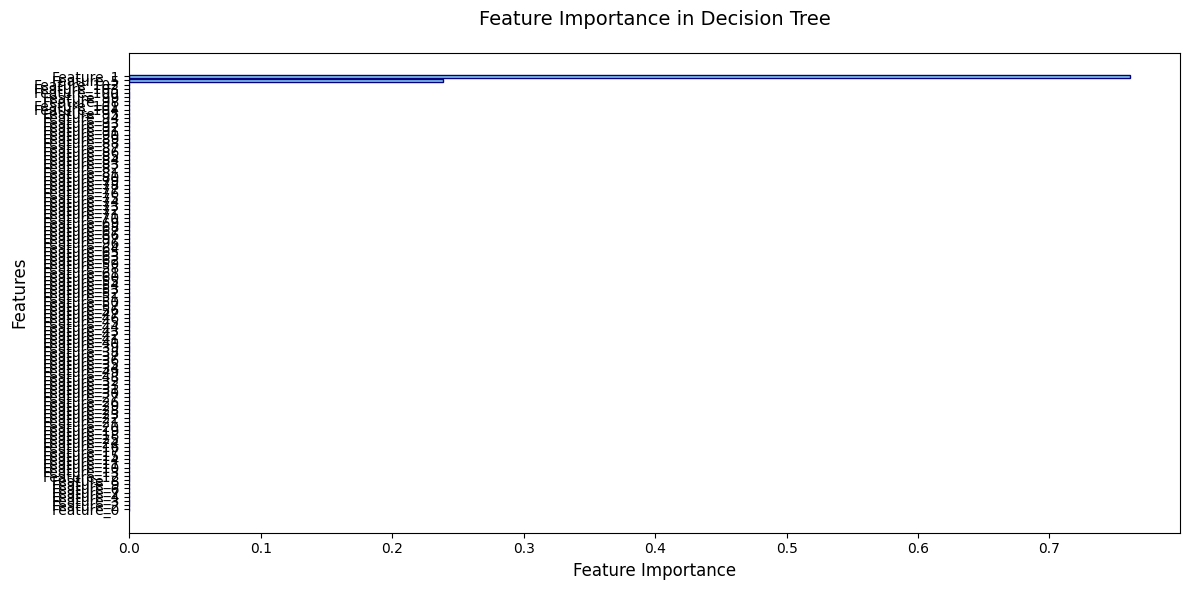


Training Set Metrics:
Accuracy: 0.8538
Precision: 0.8364
Recall: 0.8538
F1-score: 0.8412

Test Set Metrics:
Accuracy: 0.8541
Precision: 0.8370
Recall: 0.8541
F1-score: 0.8416


c:\Users\mhair\mlpractical\mlp\MLP_Project\mlpc\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mhair\mlpractical\mlp\MLP_Project\mlpc\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

# Convert PyTorch tensors to Pandas DataFrame with feature names (Feature_1, Feature_2, etc.)
X_train_df = pd.DataFrame(X_train.numpy(), columns=[f'Feature_{i}' for i in range(X_train.shape[1])])
X_test_df = pd.DataFrame(X_test.numpy(), columns=[f'Feature_{i}' for i in range(X_test.shape[1])])

class SimpleDecisionTree:
    def __init__(self, max_depth=None, min_samples_leaf=None):
        self.model = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,  # Add minimum samples per leaf
            min_samples_split=50,               # Minimum samples required to split
            max_leaf_nodes=12                   # Limit total number of leaf nodes
        )

    def fit(self, X_train, Y_train):
        self.model.fit(X_train, Y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)

    def get_feature_importances(self):
        return self.model.feature_importances_

# Initialize and train model with stricter parameters
model = SimpleDecisionTree(
    max_depth=2,              # Reduced depth
    min_samples_leaf=100      # Require at least 100 samples per leaf
)
model.fit(X_train_df, Y_train)

# Create figure with adjusted size
plt.figure(figsize=(20, 10))

# Plot tree with modified parameters
plot_tree(
    model.model,
    filled=True,
    feature_names=X_train_df.columns,  # Using feature names like Feature_1, Feature_2, etc.
    class_names=np.unique(Y_train).astype(str),
    fontsize=14,
    max_depth=2,             # Match the classifier's max_depth
    proportion=True,
    precision=1,
    rounded=True,
    impurity=False,
    node_ids=False,
    label='root',
)

# Increase spacing between nodes
plt.margins(x=0.2, y=0.2)

# Add padding around the plot
plt.tight_layout(pad=2.0)

# Customize colors
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Add title with padding
plt.title("Decision Tree Visualization (Simplified)", pad=30, fontsize=16)

# Save with high DPI and tight layout
plt.savefig('decision_tree_plot.png', 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none',
            pad_inches=0.5)

plt.show()

# Feature importance plot
plt.figure(figsize=(12, 6))
importance_data = pd.DataFrame({
    'Feature': X_train_df.columns,  # Using feature names like Feature_1, Feature_2, etc.
    'Importance': model.get_feature_importances()
}).sort_values('Importance', ascending=True)

plt.barh(importance_data['Feature'], 
         importance_data['Importance'],
         color='skyblue',
         edgecolor='navy')

plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance in Decision Tree', fontsize=14, pad=20)
plt.tight_layout()

plt.savefig('feature_importance_plot.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')

plt.show()

# Predict on the training and test sets
y_pred_train = model.predict(X_train_df)
y_pred_test = model.predict(X_test_df)

# Calculate metrics for training and test sets
train_accuracy = accuracy_score(Y_train, y_pred_train)
train_precision = precision_score(Y_train, y_pred_train, average='weighted')
train_recall = recall_score(Y_train, y_pred_train, average='weighted')
train_f1 = f1_score(Y_train, y_pred_train, average='weighted')

test_accuracy = accuracy_score(Y_test, y_pred_test)
test_precision = precision_score(Y_test, y_pred_test, average='weighted')
test_recall = recall_score(Y_test, y_pred_test, average='weighted')
test_f1 = f1_score(Y_test, y_pred_test, average='weighted')

# Print the metrics
print(f'\nTraining Set Metrics:')
print(f'Accuracy: {train_accuracy:.4f}')
print(f'Precision: {train_precision:.4f}')
print(f'Recall: {train_recall:.4f}')
print(f'F1-score: {train_f1:.4f}')

print(f'\nTest Set Metrics:')
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')
print(f'F1-score: {test_f1:.4f}')

to do:
- edit decision trees so the decision tree features have actual names, not just feature1, feature2 etc.
- reformat decision tree diagram to include as many features as possible
- reformat the feature importance for decision trees
- run baseline models on other datasets
- finalise tables and graphs for baseline models